# **Aprendizagem Supervisionada - Projeto Final**

## **Ranqueamento de Urgência das Reclamações do Consumidor.gov**

Professor: Aléssio Tony <br>
Aluno: Pedro Henrique Medeiros Vieira - 20220092900

### **Objetivo**

O objetivo **principal** será calcular a probabilidade de uma reclamação não ser resolvida e criar um ranquemento de reclamações prioritárias.

Outras ideias:

- **Classificação de tipo de problema mais frequente**<br>
    **Objetivo:** Classificar automaticamente as reclamações em categorias de problemas (ex: cobrança indevida, produto com defeito etc.), mesmo quando o usuário escreve de forma livre.

  - **Técnica:** NLP + Classificação Multiclasse (ex: Logistic Regression, Random Forest, BERT)
  - **Uso:** Facilita o direcionamento da demanda para a equipe correta.
  
- **Previsão de tempo de resposta ou resolução**<br>
    **Objetivo:** Estimar em quantos dias uma reclamação será respondida ou resolvida.

  - **Técnica:** Regressão (ex: XGBoost, SVR)
  - **Variáveis úteis:** Data da reclamação, empresa, tipo de produto, canal, localização.

- **Sistema de recomendação de ações para o consumidor**<br>
    **Objetivo:** Dado o conteúdo da reclamação e outras variáveis, sugerir o que o consumidor pode fazer (ex: entrar em contato com PROCON, abrir processo no Juizado, aguardar prazo médio, etc.)

  - **Técnica:** Regras + Classificação baseada em casos anteriores (similaridade)

---

### **Análise Exploratória de Dados e Preparação**

O presente notebook contém as análises de dados exploratórias desenvolvidas para extrair insights para a preparação e modelagem do projeto.

Os dados foram extraídos do site: [Consumidor.gov](https://consumidor.gov.br/pages/indicador/relatos/abrir), um site em que consumidores e empresas resolvem conflitos de consumo por meio da internet, sem precisar de um processo judicial.

A extração foi automatizada por WebScrapping, com Selenium e BeatifulSoup.

In [387]:
# Import modules
from pandas import read_csv
import os

In [388]:
# Files vars
data_dir = 'data'
file_name = 'relatos.csv'

dir_path = os.path.dirname(os.getcwd())
data_path = os.path.join(dir_path, data_dir)
file_path = os.path.join(data_path, file_name)

# Data reading
data = read_csv(file_path, sep='|', encoding='utf-8')
data.head()

,ID,Company_Name,Status,Date,Report,Company_Response,Response_Date,Rating_Score,Consumer_Written_Evaluation
0,0,Natura,Não Resolvido,"14/04/2025, Buritama - SP","A Natura vem me fazendo ligações, me passando ...","Olá Larissa, boa noite!\n\nTudo bem? Esperamos...",(no mesmo dia),Nota 1,Não aparece a resposta da empresa
1,1,Enel Distribuição Rio (Ampla),Resolvido,"14/04/2025, Maricá - RJ",PARCELAMENTO MUTIRAO ENEL MARICÁ,"Olá, Luiz!\nAgradecemos o seu contato e a opor...",(no mesmo dia),Nota 3,Resolvendo o problema
2,2,Dog Life,Resolvido,"14/04/2025, Manaus - AM",Boa tarde!\n\nFiz a contratação do plano Dog L...,"Olá, Janaina,\n\nAgradecemos seu contato e lam...",(no mesmo dia),Nota 5,A empresa entrou em contato via fone para solu...
3,3,Serasa Experian,Não Resolvido,"14/04/2025, Rio de Janeiro - RJ",Foi realizado a consulta do meu CPF pela empre...,"Oi, ROSANE. Tudo bem?\n\n\nAcabamos de respond...",(no mesmo dia),Nota 1,Não foi excluído minhas consultas
4,4,Serasa Experian,Resolvido,"14/04/2025, São Paulo - SP",Em 03 de março de 2025 verifiquei consultei a ...,"Oi, Nelson. Tudo bem?\n\n\nAcabamos de respond...",(no mesmo dia),Nota 3,<não há comentários do consumidor>


In [389]:
# Info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13500 entries, 0 to 13499
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   ID                           13500 non-null  int64 
 1   Company_Name                 13500 non-null  object
 2   Status                       13500 non-null  object
 3   Date                         13500 non-null  object
 4   Report                       13500 non-null  object
 5   Company_Response             13500 non-null  object
 6   Response_Date                13373 non-null  object
 7   Rating_Score                 13500 non-null  object
 8   Consumer_Written_Evaluation  13500 non-null  object
dtypes: int64(1), object(8)
memory usage: 949.3+ KB


Dados em formatos errados:

- Date: Possui local e data
- Response_Date: Possui texto
- Rating_Score: Em texto

In [390]:
# Dados nulos
data.isna().sum()

ID                               0
Company_Name                     0
Status                           0
Date                             0
Report                           0
Company_Response                 0
Response_Date                  127
Rating_Score                     0
Consumer_Written_Evaluation      0
dtype: int64

In [391]:
# Visualizando dados nulos
data[data.isna().any(axis=1)]

,ID,Company_Name,Status,Date,Report,Company_Response,Response_Date,Rating_Score,Consumer_Written_Evaluation
584,584,Serasa Experian,Não Resolvido,"09/04/2025, Osasco - SP","Conforme decisão do STJ, dividas prescritas nã...",<não respondido pela empresa>,NaN,Nota 1,O Serasa vendeu a tal divida e obrigação de vo...
1128,1128,Serasa Experian,Resolvido,"08/04/2025, Queimados - RJ","o dia 31/03/2025, realizei o pagamento integra...",<não respondido pela empresa>,NaN,Nota 5,"Obrigado, consumidor.gov pela ajuda."
1335,1335,Serasa Experian,Não Resolvido,"08/04/2025, São Paulo - SP","Conforme decisão do STJ, dívidas com mais de 5...",<não respondido pela empresa>,NaN,Nota 1,Eu quero que retire essa dívida do Serasa.
1999,1999,Serasa Experian,Resolvido,"07/04/2025, Nilópolis - RJ","Conforme decisão do STJ , dividas prescritas n...",<não respondido pela empresa>,NaN,Nota 1,<não há comentários do consumidor>
3448,3448,Serasa Experian,Resolvido,"04/04/2025, Barreiras - BA",À SERASA EXPERIAN\nAssunto: Solicitação de Ret...,<não respondido pela empresa>,NaN,Nota 5,Agradeço pela pronta resolução do referido pro...
...,...,...,...,...,...,...,...,...,...
13339,13339,NotreDame Intermédica,Não Resolvido,"27/03/2025, Brasília - DF",Trata-se da análise das cobranças derivadas do...,<não respondido pela empresa>,NaN,Nota 1,"Se esquivam o tempo todo, não respondem, não a..."
13354,13354,NotreDame Intermédica,Não Resolvido,"27/03/2025, São Paulo - SP",REALIZEI A PORTABILIDADE E FUI INFORMADO QUE N...,<não respondido pela empresa>,NaN,Nota 1,NAO FOI RESOLVIDO NADA NAO FOI ANALISADO CORRE...
13380,13380,L4B Logística (Loggi XD),Não Resolvido,"27/03/2025, Brasília - DF",Realizei o meu pedido no site foto registro co...,<não respondido pela empresa>,NaN,Nota 1,"Sumiram com meu pedido, nao resolveram o meu p..."
13410,13410,NotreDame Intermédica,Resolvido,"27/03/2025, São José dos Campos - SP",Estamos tentando agendar um simples exame de m...,<não respondido pela empresa>,NaN,Nota 3,Exame agendado


É intuitivo dizer que a coluna de Data da Resposta da empresa é nula quando a empresa ainda não respondeu. Como são informações possivelmente úteis, vamos preservá-las.

---

### **Corrigindo formatos**

Dados em formatos errados:

- Date: Possui local e data
- Response_Date: Possui texto
- Rating_Score: Em texto

In [392]:
# Date
data['Date'].loc[0:5]

0          14/04/2025, Buritama - SP
1            14/04/2025, Maricá - RJ
2            14/04/2025, Manaus - AM
3    14/04/2025, Rio de Janeiro - RJ
4         14/04/2025, São Paulo - SP
5          14/04/2025, São Luís - MA
Name: Date, dtype: object

In [393]:
from pandas import to_datetime

data = (
    data.assign(
        data_reclamacao=lambda x: to_datetime(x.Date.str.split(',').str[0], format='%d/%m/%Y'),
        local=lambda x: x.Date.str.split(',').str[1].str.strip(),
        cidade=lambda x: x.local.str.split('-').str[0].str.strip(),
        uf=lambda x: x.local.str.split('-').str[-1].str.strip(),
    ).drop(columns=['Date', 'local'])
)

In [394]:
print('Dados')
display(data[['data_reclamacao', 'cidade', 'uf']].head())

print('\nTipos')
data[['data_reclamacao', 'cidade', 'uf']].dtypes

Dados


,data_reclamacao,cidade,uf
0,2025-04-14,Buritama,SP
1,2025-04-14,Maricá,RJ
2,2025-04-14,Manaus,AM
3,2025-04-14,Rio de Janeiro,RJ
4,2025-04-14,São Paulo,SP



Tipos


data_reclamacao    datetime64[ns]
cidade                     object
uf                         object
dtype: object

---

### **Datas**

In [395]:
# Response Date
data['Response_Date'].loc[0:5]

0    (no mesmo dia)
1    (no mesmo dia)
2    (no mesmo dia)
3    (no mesmo dia)
4    (no mesmo dia)
5    (no mesmo dia)
Name: Response_Date, dtype: object

In [396]:
data['Response_Date'].unique()

array(['(no mesmo dia)', '(1 dia(s) depois)', '(2 dia(s) depois)',
       '(3 dia(s) depois)', '(4 dia(s) depois)', '(5 dia(s) depois)', nan,
       '(6 dia(s) depois)', '(7 dia(s) depois)', '(8 dia(s) depois)',
       '(9 dia(s) depois)', '(10 dia(s) depois)', '(12 dia(s) depois)',
       '(13 dia(s) depois)', '(11 dia(s) depois)', '(15 dia(s) depois)',
       '(14 dia(s) depois)', '(17 dia(s) depois)', '(18 dia(s) depois)'],
      dtype=object)

Vou transformar essa coluna em dia para resposta, e criar outra coluna binária 'respondido'.

In [397]:
from pandas import isnull
from numpy import nan
from re import search

def get_days(value):
    if isnull(value):
        return -1
    if value == '(no mesmo dia)':
        return 0
    
    match = search(r'(\d+)', value)
    return int(match.group(1)) if match else nan

data = (
    data.assign(
        respondido=lambda x: x.Response_Date.notnull().astype(int),
        dias_para_resposta=lambda x: x.Response_Date.apply(get_days).astype(int),
    ).drop(columns=['Response_Date'])
) 


In [398]:
data.head()

,ID,Company_Name,Status,Report,Company_Response,Rating_Score,Consumer_Written_Evaluation,data_reclamacao,cidade,uf,respondido,dias_para_resposta
0,0,Natura,Não Resolvido,"A Natura vem me fazendo ligações, me passando ...","Olá Larissa, boa noite!\n\nTudo bem? Esperamos...",Nota 1,Não aparece a resposta da empresa,2025-04-14,Buritama,SP,1,0
1,1,Enel Distribuição Rio (Ampla),Resolvido,PARCELAMENTO MUTIRAO ENEL MARICÁ,"Olá, Luiz!\nAgradecemos o seu contato e a opor...",Nota 3,Resolvendo o problema,2025-04-14,Maricá,RJ,1,0
2,2,Dog Life,Resolvido,Boa tarde!\n\nFiz a contratação do plano Dog L...,"Olá, Janaina,\n\nAgradecemos seu contato e lam...",Nota 5,A empresa entrou em contato via fone para solu...,2025-04-14,Manaus,AM,1,0
3,3,Serasa Experian,Não Resolvido,Foi realizado a consulta do meu CPF pela empre...,"Oi, ROSANE. Tudo bem?\n\n\nAcabamos de respond...",Nota 1,Não foi excluído minhas consultas,2025-04-14,Rio de Janeiro,RJ,1,0
4,4,Serasa Experian,Resolvido,Em 03 de março de 2025 verifiquei consultei a ...,"Oi, Nelson. Tudo bem?\n\n\nAcabamos de respond...",Nota 3,<não há comentários do consumidor>,2025-04-14,São Paulo,SP,1,0


---

### **Notas**

In [399]:
data['Rating_Score'].unique()

array(['Nota 1', 'Nota 3', 'Nota 5', 'Nota 4', 'Nota 2'], dtype=object)

In [400]:
data = (
    data.assign(
        nota=lambda x: x.Rating_Score.str.extract(r'(\d+)').astype(int)
    ).drop(columns=['Rating_Score'])
)

In [401]:
data.head()

,ID,Company_Name,Status,Report,Company_Response,Consumer_Written_Evaluation,data_reclamacao,cidade,uf,respondido,dias_para_resposta,nota
0,0,Natura,Não Resolvido,"A Natura vem me fazendo ligações, me passando ...","Olá Larissa, boa noite!\n\nTudo bem? Esperamos...",Não aparece a resposta da empresa,2025-04-14,Buritama,SP,1,0,1
1,1,Enel Distribuição Rio (Ampla),Resolvido,PARCELAMENTO MUTIRAO ENEL MARICÁ,"Olá, Luiz!\nAgradecemos o seu contato e a opor...",Resolvendo o problema,2025-04-14,Maricá,RJ,1,0,3
2,2,Dog Life,Resolvido,Boa tarde!\n\nFiz a contratação do plano Dog L...,"Olá, Janaina,\n\nAgradecemos seu contato e lam...",A empresa entrou em contato via fone para solu...,2025-04-14,Manaus,AM,1,0,5
3,3,Serasa Experian,Não Resolvido,Foi realizado a consulta do meu CPF pela empre...,"Oi, ROSANE. Tudo bem?\n\n\nAcabamos de respond...",Não foi excluído minhas consultas,2025-04-14,Rio de Janeiro,RJ,1,0,1
4,4,Serasa Experian,Resolvido,Em 03 de março de 2025 verifiquei consultei a ...,"Oi, Nelson. Tudo bem?\n\n\nAcabamos de respond...",<não há comentários do consumidor>,2025-04-14,São Paulo,SP,1,0,3


Dados limpos e formatados, vamos partir para as análises.

---

## **Análise Exploratória de Dados**

Principais perguntas a serem respondidas:

- 1. De quantas empresas tenho reclamações?
- 2. Quais as empresas com mais reclamações?
- 3. A quantidade de reclamações está correlacionada com a chance de ser resolvida?
- 4. A média de nota por empresa
- 5. Média de nota por reclamações não resolvidas
- 6. Distribuição de reclamações resolvidas e não-resolvidas.

**PLN - Processamento de Linguagem Natural**
- 7. Palavras mais frequentes
- 8. Palavras mais frequentes por empresa.
- 9. Palavras mais frequentes nos resolvidos e não resolvidos.

In [402]:
import matplotlib.pyplot as plt
import seaborn as sns

In [403]:
# 1. De quantas empresas tenho reclamações?
print('Empresas únicas nas reclamações:', len(data['Company_Name'].unique()))
print('Reclamações totais:', len(data))

Empresas únicas nas reclamações: 671
Reclamações totais: 13500


In [404]:
# 2. Quantas reclamações por empresa?
print('Top 10 empresas com mais reclamações:')
data['Company_Name'].value_counts().sort_values(ascending=False).head(10).to_frame()

print(f'\nMédia de reclamações por empresa: {data["Company_Name"].value_counts().mean():.2f}')	

Top 10 empresas com mais reclamações:

Média de reclamações por empresa: 20.12


In [405]:
# 3. A quantidade de reclamações está correlacionada com a chance de ser resolvida?
taxas = (
    data.assign(
        resolvido=lambda x: (x.Status == 'Resolvido').astype(int),
        nao_resolvido=lambda x: (x.Status != 'Resolvido').astype(int)
    ).groupby('Company_Name').agg(
        total_reclamacoes=('Company_Name', 'count'),
        total_resolvido=('resolvido', 'sum'),
        total_nao_resolvido=('nao_resolvido', 'sum')
    ).assign(
        taxa_resolucao=lambda x: x.total_resolvido / x.total_reclamacoes * 100,
        taxa_nao_resolucao=lambda x: x.total_nao_resolvido / x.total_reclamacoes * 100,
    ).reset_index()
     .sort_values(
        by='total_reclamacoes', 
        ascending=False
    )
)

taxas.head()

,Company_Name,total_reclamacoes,total_resolvido,total_nao_resolvido,taxa_resolucao,taxa_nao_resolucao
553,Serasa Experian,911,324,587,35.565313,64.434687
641,Vivo - Telefônica,622,551,71,88.585209,11.414791
100,Banco do Brasil,485,211,274,43.505155,56.494845
374,Latam Airlines (Tam),426,370,56,86.854460,13.145540
158,Caixa Econômica Federal,398,201,197,50.502513,49.497487


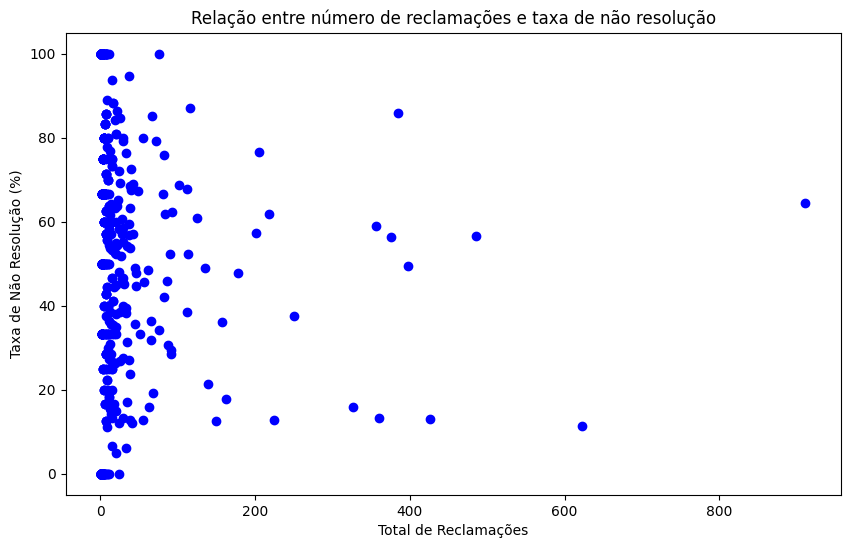

In [406]:
plt.figure(figsize=(10, 6))
plt.scatter(taxas['total_reclamacoes'], taxas['taxa_nao_resolucao'], color='blue')

plt.title('Relação entre número de reclamações e taxa de não resolução')
plt.xlabel('Total de Reclamações')
plt.ylabel('Taxa de Não Resolução (%)')

plt.show()

Podemos ver que não há uma relação clara, tanto que, já visualizando a tabela, temos os exemplos:

|     | Company_Name            |   total_reclamacoes |   total_resolvido |   total_nao_resolvido |   taxa_resolucao |   taxa_nao_resolucao |
|----:|:------------------------|--------------------:|------------------:|----------------------:|-----------------:|---------------------:|
| 553 | Serasa Experian         |                 911 |               324 |                   587 |          35.5653 |              64.4347 |
| 641 | Vivo - Telefônica       |                 622 |               551 |                    71 |          88.5852 |              11.4148 |
| 100 | Banco do Brasil         |                 485 |               211 |                   274 |          43.5052 |              56.4948 |
| 374 | Latam Airlines (Tam)    |                 426 |               370 |                    56 |          86.8545 |              13.1455 |
| 158 | Caixa Econômica Federal |                 398 |               201 |                   197 |          50.5025 |              49.4975 |

Em que a **Serasa Experian** é a empresa com mais reclamações e possui uma baixa taxa de resolução, enquanto a **Vivo** possui várias reclamações mas uma alta taxa de resolução.

In [407]:
# 4. A média de nota por empresa
agg_data = data.groupby('Company_Name').agg(
    media_nota=('nota', 'mean'),
    quantidade_reclamacoes=('Company_Name', 'count'),
).sort_values(
    by='quantidade_reclamacoes', 
    ascending=False
).reset_index()

agg_data

,Company_Name,media_nota,quantidade_reclamacoes
0,Serasa Experian,2.635565,911
1,Vivo - Telefônica,4.299035,622
2,Banco do Brasil,2.773196,485
3,Latam Airlines (Tam),4.368545,426
4,Caixa Econômica Federal,2.824121,398
...,...,...,...
666,Odonto Empresas,5.000000,1
667,Black & Decker,1.000000,1
668,"Bimbo do Brasil (Pullman, Plusvita, Ana Maria,...",4.000000,1
669,BetMGM,1.000000,1


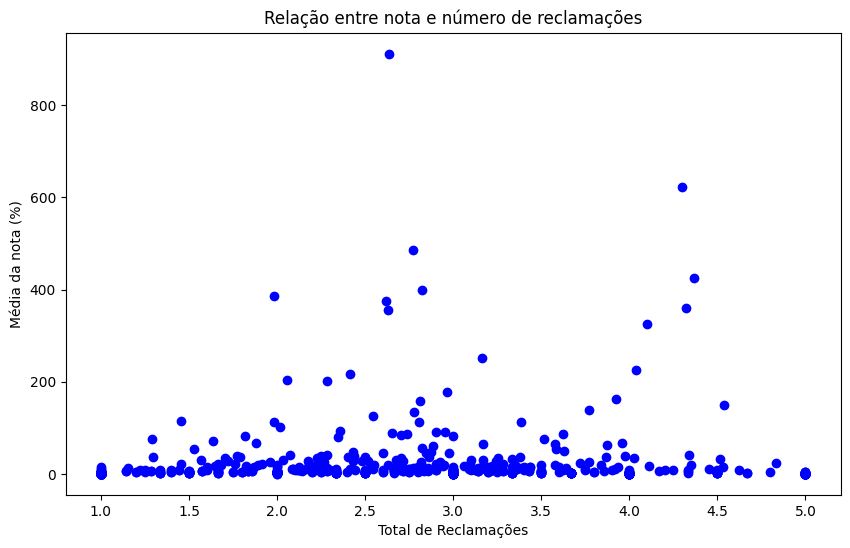

In [408]:
plt.figure(figsize=(10, 6))
plt.scatter(agg_data['media_nota'], agg_data['quantidade_reclamacoes'], color='blue')

plt.title('Relação entre nota e número de reclamações')
plt.xlabel('Total de Reclamações')
plt.ylabel('Média da nota (%)')

plt.show()

In [409]:
# 5. Média de nota por reclamações não resolvidas & 6. Distribuição de reclamações resolvidas e não-resolvidas.
score_per_status = (
    data.groupby('Status').agg(
        media_nota=('nota', 'mean'),
        quantidade_reclamacoes=('Company_Name', 'count')
    ).reset_index()
)

score_per_status

,Status,media_nota,quantidade_reclamacoes
0,Não Resolvido,1.419533,6338
1,Resolvido,4.277576,7162


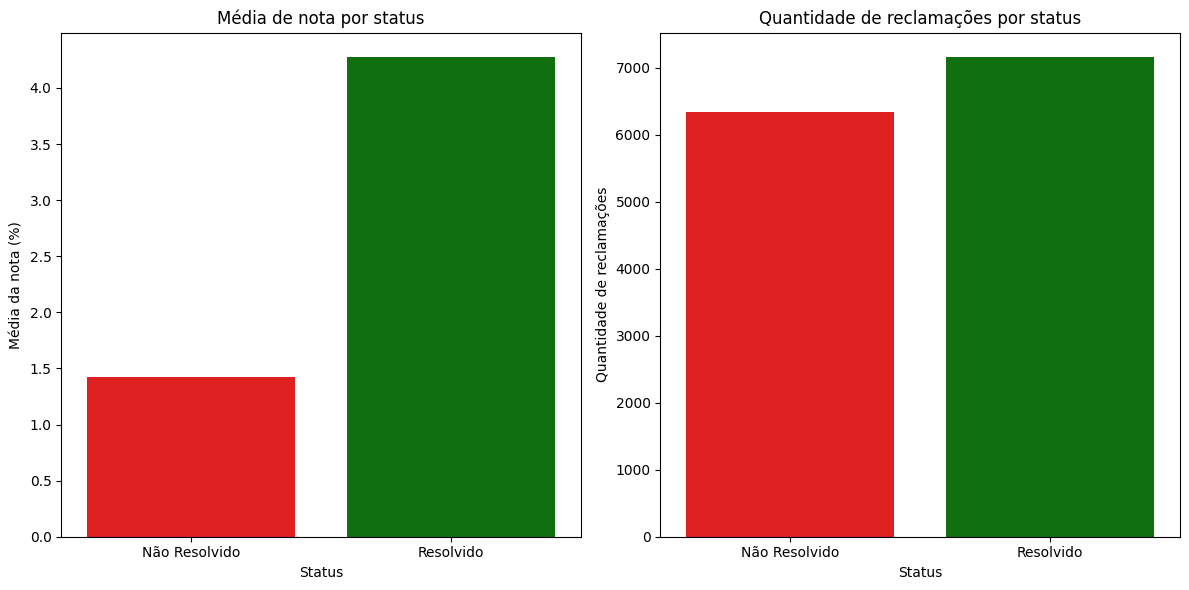

In [410]:
# Green for resolved, red for unresolved
import warnings
warnings.filterwarnings('ignore')

colors = ['green' if status == 'Resolvido' else 'red' for status in score_per_status['Status']]
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(data=score_per_status, x='Status', y='media_nota', ax=ax[0], palette=colors)
ax[0].set_title('Média de nota por status')
ax[0].set_xlabel('Status')
ax[0].set_ylabel('Média da nota (%)')

sns.barplot(data=score_per_status, x='Status', y='quantidade_reclamacoes', ax=ax[1], palette=colors)
ax[1].set_title('Quantidade de reclamações por status')
ax[1].set_xlabel('Status')
ax[1].set_ylabel('Quantidade de reclamações')

plt.tight_layout()
plt.show()

**PLN - Processamento de Linguagem Natural**
- 7. Palavras mais frequentes
- 8. Palavras mais frequentes por empresa.
- 9. Palavras mais frequentes nos resolvidos e não resolvidos.

In [307]:
import pandas as pd
import nltk
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [308]:
import re

def preprocess_text(text):
    # Remove pontuação, números e deixa tudo minúsculo
    text = re.sub(r'[^a-zA-ZáéíóúãõâêôçÁÉÍÓÚÃÕÂÊÔÇ]', ' ', text)
    text = text.lower()
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return ' '.join(tokens)


In [266]:
from pandas import DataFrame

# Pré-processa todas as descrições
data['clean_report'] = data['Report'].apply(preprocess_text)

# Junta tudo num só texto
all_words = ' '.join(data['clean_report']).split()

# Conta frequência
top_words = Counter(all_words).most_common(20)
print('Top 20 palavras mais frequentes:')

freq_df = DataFrame(top_words, columns=['word', 'frequency'])
freq_df = freq_df.sort_values(by='frequency', ascending=False).reset_index(drop=True)
freq_df

Top 20 palavras mais frequentes:


,word,frequency
0,dia,8666
1,valor,8191
2,xxx,7730
3,contato,4935
4,conta,4663
5,empresa,4515
6,pois,4383
7,banco,4283
8,pagamento,3086
9,compra,3071


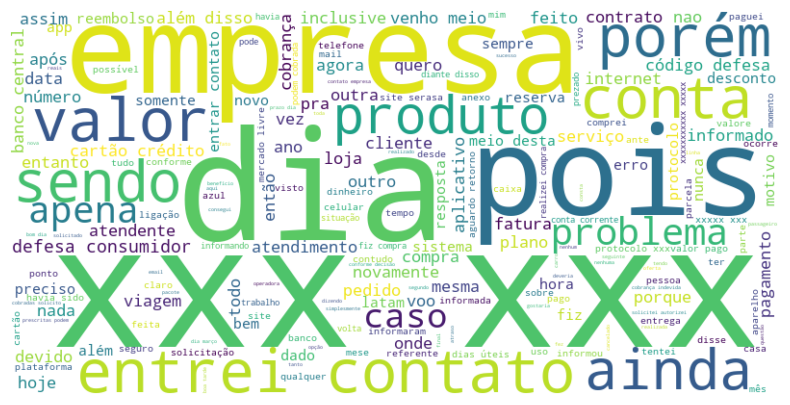

In [267]:
# Word Cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [268]:
# Lista para armazenar os dados
freq_data = []

# Iterar pelos status
for company in data['Company_Name'].unique():
    subset = data[data['Company_Name'] == company]
    texto = ' '.join(subset['clean_report'])
    palavras = texto.split()
    top = Counter(palavras).most_common(10)

    # Adiciona ao dataframe
    for palavra, freq in top:
        freq_data.append({'empresa': company, 'Palavra': palavra, 'Frequência': freq})

# Criar o DataFrame
df_frequencia_status = DataFrame(freq_data)

In [269]:
# Lista para armazenar os dados
freq_data = []

# Iterar pelos status
for status in data['Status'].unique():
    subset = data[data['Status'] == status]
    texto = ' '.join(subset['clean_report'])
    palavras = texto.split()
    top = Counter(palavras).most_common(10)

    # Adiciona ao dataframe
    for palavra, freq in top:
        freq_data.append({'Status': status, 'Palavra': palavra, 'Frequência': freq})

# Criar o DataFrame
df_frequencia_status = DataFrame(freq_data)

In [270]:
print('Frequência de palavras por status Resolvido:')
df_frequencia_status[df_frequencia_status['Status'] == 'Resolvido'][['Palavra', 'Frequência']].head(10)

Frequência de palavras por status Resolvido:


,Palavra,Frequência
10,dia,5181
11,valor,4369
12,xxx,4285
13,contato,2800
14,empresa,2287
15,pois,2170
16,conta,2106
17,cancelamento,1920
18,plano,1756
19,compra,1756


In [271]:
print('Frequência de palavras por status Não-Resolvido:')
df_frequencia_status[df_frequencia_status['Status'] == 'Não Resolvido'][['Palavra', 'Frequência']].head(10)

Frequência de palavras por status Não-Resolvido:


,Palavra,Frequência
0,valor,3822
1,dia,3485
2,xxx,3445
3,banco,2731
4,conta,2557
5,empresa,2228
6,pois,2213
7,contato,2135
8,cartão,1585
9,nome,1538


---
## **Preparação de Dados**

In [411]:
# Preparação de dados para modelagem com Machine Learning
cols = [col for col in data.columns if col not in ['Report', 'clean_report', 'Company_Response','Consumer_Written_Evaluation']]
data[cols].head()

,ID,Company_Name,Status,data_reclamacao,cidade,uf,respondido,dias_para_resposta,nota
0,0,Natura,Não Resolvido,2025-04-14,Buritama,SP,1,0,1
1,1,Enel Distribuição Rio (Ampla),Resolvido,2025-04-14,Maricá,RJ,1,0,3
2,2,Dog Life,Resolvido,2025-04-14,Manaus,AM,1,0,5
3,3,Serasa Experian,Não Resolvido,2025-04-14,Rio de Janeiro,RJ,1,0,1
4,4,Serasa Experian,Resolvido,2025-04-14,São Paulo,SP,1,0,3


In [412]:
# Removendo colunas inúteis
data_ml = data.drop(columns=['ID', 'data_reclamacao', 'cidade', 'Consumer_Written_Evaluation'])
data_ml.head()

,Company_Name,Status,Report,Company_Response,uf,respondido,dias_para_resposta,nota
0,Natura,Não Resolvido,"A Natura vem me fazendo ligações, me passando ...","Olá Larissa, boa noite!\n\nTudo bem? Esperamos...",SP,1,0,1
1,Enel Distribuição Rio (Ampla),Resolvido,PARCELAMENTO MUTIRAO ENEL MARICÁ,"Olá, Luiz!\nAgradecemos o seu contato e a opor...",RJ,1,0,3
2,Dog Life,Resolvido,Boa tarde!\n\nFiz a contratação do plano Dog L...,"Olá, Janaina,\n\nAgradecemos seu contato e lam...",AM,1,0,5
3,Serasa Experian,Não Resolvido,Foi realizado a consulta do meu CPF pela empre...,"Oi, ROSANE. Tudo bem?\n\n\nAcabamos de respond...",RJ,1,0,1
4,Serasa Experian,Resolvido,Em 03 de março de 2025 verifiquei consultei a ...,"Oi, Nelson. Tudo bem?\n\n\nAcabamos de respond...",SP,1,0,3


In [413]:
#data_ml = (
#    pd.concat(
#        [
#            data_ml.drop(columns=['Company_Name', 'uf']), 
#            pd.get_dummies(data_ml, columns=['Company_Name', 'uf'])
#              .select_dtypes(include=['bool'])
#              .astype(int)
#        ], 
#        axis=1
#    )
#) 

In [414]:
data_ml.head()

,Company_Name,Status,Report,Company_Response,uf,respondido,dias_para_resposta,nota
0,Natura,Não Resolvido,"A Natura vem me fazendo ligações, me passando ...","Olá Larissa, boa noite!\n\nTudo bem? Esperamos...",SP,1,0,1
1,Enel Distribuição Rio (Ampla),Resolvido,PARCELAMENTO MUTIRAO ENEL MARICÁ,"Olá, Luiz!\nAgradecemos o seu contato e a opor...",RJ,1,0,3
2,Dog Life,Resolvido,Boa tarde!\n\nFiz a contratação do plano Dog L...,"Olá, Janaina,\n\nAgradecemos seu contato e lam...",AM,1,0,5
3,Serasa Experian,Não Resolvido,Foi realizado a consulta do meu CPF pela empre...,"Oi, ROSANE. Tudo bem?\n\n\nAcabamos de respond...",RJ,1,0,1
4,Serasa Experian,Resolvido,Em 03 de março de 2025 verifiquei consultei a ...,"Oi, Nelson. Tudo bem?\n\n\nAcabamos de respond...",SP,1,0,3


In [415]:
data_ml.rename(columns=lambda x: x.lower(), inplace=True)

In [416]:
data_ml = (
    data_ml.assign(
        status=lambda x: (x.status == 'Resolvido').astype(int),
    )
)

In [418]:
# Salvando em data
data_ml.to_csv(os.path.join(data_path, 'relatos_ml_gzip.csv'), sep='|', index=False, encoding='utf-8', compression='gzip')
print('Arquivo salvo com sucesso!')

Arquivo salvo com sucesso!
